# Final Project

Target: Given a match between two teams of the FIFA 2022 World Cup, what is the result of the match?

## First exploration on the data

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, make_scorer

In [2]:
# Reading the dataset
df_raw = pd.read_csv("../data/raw/results.csv")

Content
This dataset includes 43,170 results of international football matches starting from the very first official match in 1872 up to 2022. The matches range from FIFA World Cup to FIFI Wild Cup to regular friendly matches. The matches are strictly men's full internationals and the data does not include Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.

results.csv includes the following columns:

**date** - date of the match

**home_team** - the name of the home team

**away_team** - the name of the away team

**home_score** - full-time home team score including extra time, not including penalty-shootouts

**away_score** - full-time away team score including extra time, not including penalty-shootouts

**tournament** - the name of the tournament

**city** - the name of the city/town/administrative unit where the match was played

**country** - the name of the country where the match was played

**neutral** - TRUE/FALSE column indicating whether the match was played at a neutral venue

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43752 entries, 0 to 43751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        43752 non-null  object
 1   home_team   43752 non-null  object
 2   away_team   43752 non-null  object
 3   home_score  43752 non-null  int64 
 4   away_score  43752 non-null  int64 
 5   tournament  43752 non-null  object
 6   city        43752 non-null  object
 7   country     43752 non-null  object
 8   neutral     43752 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.7+ MB


In [4]:
df_raw.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### Descriptive Statistics 

In [5]:
round(df_raw.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
home_score,43752.0,2.0,2.0,0.0,1.0,1.0,2.0,31.0
away_score,43752.0,1.0,1.0,0.0,0.0,1.0,2.0,21.0


In [6]:
df_raw.describe(include="O").transpose()

,count,unique,top,freq
date,43752,15462,2012-02-29,66
home_team,43752,306,Brazil,589
away_team,43752,303,Uruguay,556
tournament,43752,135,Friendly,17362
city,43752,1995,Kuala Lumpur,675
country,43752,267,United States,1251


### Null Values

In [7]:
df_raw.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

### Duplicated data

In [8]:
df_raw.duplicated().sum()

0

### Unique values

In [9]:
# Unique values
df_raw.nunique()

date          15462
home_team       306
away_team       303
home_score       26
away_score       22
tournament      135
city           1995
country         267
neutral           2
dtype: int64

* The dataset doesn't have duplicated data or null values.

## Visualization and transformation of the data

In [10]:
# We make a copy of the original dataset
df = df_raw.copy()

### Number of Matches played in equal intervals

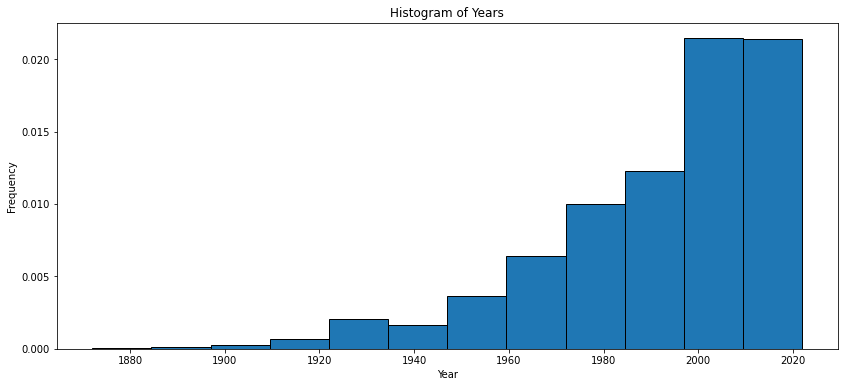

In [11]:
years = []
for date in df_raw.date:
    years.append(int(str(date)[0:4]))
plt.figure(figsize=(14,6))
plt.hist(years, density=True, bins=12, edgecolor="k")
plt.title("Histogram of Years")
plt.ylabel("Frequency")
plt.xlabel("Year")
plt.show()

* We can observe that most matches are played after 1960 with a even greater increment after 2000.

In [12]:
# We split the date and store the year information in another column
df["year"]=pd.DatetimeIndex(df["date"]).year

In [13]:
# Top 15 years with the most played games
top_15 = pd.DataFrame(df["year"].value_counts().head(15))
top_15.columns=["Number of games"]
print(top_15)

      Number of games
2019             1161
2008             1095
2021             1087
2011             1083
2004             1066
2000             1026
2001             1022
2012             1007
2015             1002
2007              975
2013              968
2017              959
2003              935
2016              928
2009              912


### Date Feature

Looking at the information obtained about the matches per year, in our case we decide to remove the data before 2010.

We will change the format for the feature Data and eliminate the registers before 2010.

In [14]:
# Date feature format to datetime (format: YEAR-MONTH-DAY --> %Y-%m-%d)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43752 entries, 0 to 43751
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        43752 non-null  datetime64[ns]
 1   home_team   43752 non-null  object        
 2   away_team   43752 non-null  object        
 3   home_score  43752 non-null  int64         
 4   away_score  43752 non-null  int64         
 5   tournament  43752 non-null  object        
 6   city        43752 non-null  object        
 7   country     43752 non-null  object        
 8   neutral     43752 non-null  bool          
 9   year        43752 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 3.0+ MB


In [16]:
# Elimination of registers before 2012
date_lb = pd.Timestamp(2012,1,1)
df = df[(df['date'] > date_lb)]

In [17]:
df = df.drop(['date'], axis=1)

In [18]:
df.head(10)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
33980,Equatorial Guinea,South Africa,0,0,Friendly,Bata,Equatorial Guinea,False,2012
33981,Botswana,Zimbabwe,0,0,Friendly,Gaborone,Botswana,False,2012
33982,Gabon,Burkina Faso,0,0,Friendly,Bitam,Gabon,False,2012
33983,Tunisia,Sudan,3,0,Friendly,Sharjah,United Arab Emirates,True,2012
33984,Nigeria,Angola,0,0,Friendly,Abuja,Nigeria,False,2012
33985,Senegal,Sudan,1,0,Friendly,Dakar,Senegal,False,2012
33986,Tunisia,Ivory Coast,0,2,Friendly,Abu Dhabi,United Arab Emirates,True,2012
33987,Angola,Sierra Leone,3,1,Friendly,Cabinda,Angola,False,2012
33988,Zambia,Namibia,0,0,Friendly,Johannesburg,South Africa,True,2012
33989,Oman,DR Congo,2,2,Friendly,Muscat,Oman,False,2012


### Outliers

For outlier analysis, we first visualize the data by plotting it with a boxplot, and if we observe outliers, we use IQR method to set the bounds. 

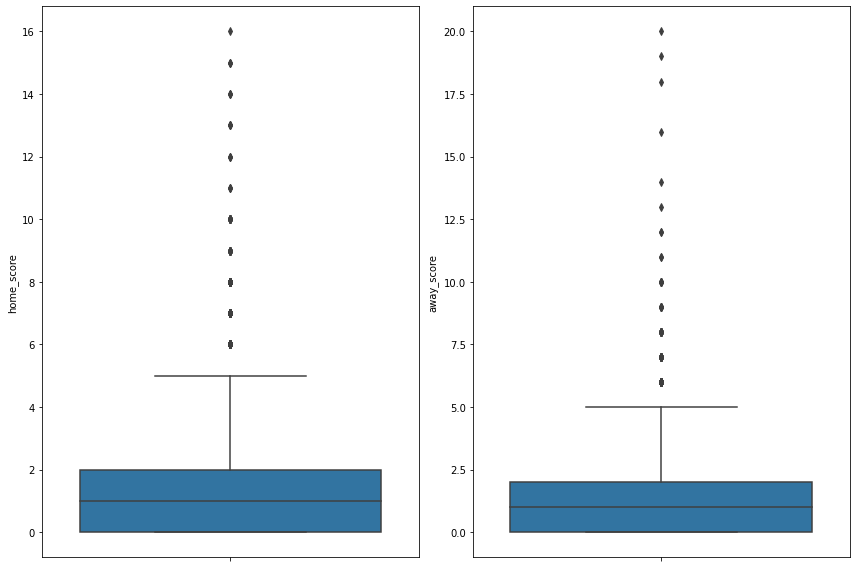

In [19]:
#Box plots for the numerical columns
f, ax = plt.subplots(1,2, figsize=(12,8))
sns.color_palette("deep")

sns.boxplot(y = df['home_score'], ax=ax[0]) 
sns.boxplot(y = df['away_score'], ax=ax[1])

plt.tight_layout()

plt.draw()

#### Evaluation of outliers implementing IQR method

In [20]:
# Using the IQR method function
def iqr_calc(col_name):
  stat = df[f'{col_name}'].describe()
  print(stat)
  IQR = stat['75%']-stat['25%']
  upper = stat['75%'] + 1.5*IQR
  lower = stat['25%'] - 1.5*IQR
  rows_out= df[df[f'{col_name}'] > upper].count()
  return f'In the {col_name} case the upper & lower for bounds for suspected outliers are {upper} and {lower}. Total of row off upper bound \n{rows_out} \n'

print(iqr_calc('home_score'))
print("\n")
print(iqr_calc('away_score'))

count    9772.000000
mean        1.591691
std         1.630385
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: home_score, dtype: float64
In the home_score case the upper & lower for bounds for suspected outliers are 5.0 and -3.0. Total of row off upper bound 
home_team     277
away_team     277
home_score    277
away_score    277
tournament    277
city          277
country       277
neutral       277
year          277
dtype: int64 



count    9772.000000
mean        1.095886
std         1.356485
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        20.000000
Name: away_score, dtype: float64
In the away_score case the upper & lower for bounds for suspected outliers are 5.0 and -3.0. Total of row off upper bound 
home_team     118
away_team     118
home_score    118
away_score    118
tournament    118
city          118
country       118
neutral       118
year          118
dtype: int6

#### Deletion of outliers

With the information about the bounds, we remove the registers with away_score and home_score greater than the upper bound.

In [21]:
# Remove the outliers for home_score
df=df.drop(df[df['home_score'] > 5].index)

# Remove the outliers for away_score
df=df.drop(df[df['away_score'] > 5].index)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9377 entries, 33980 to 43751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   home_team   9377 non-null   object
 1   away_team   9377 non-null   object
 2   home_score  9377 non-null   int64 
 3   away_score  9377 non-null   int64 
 4   tournament  9377 non-null   object
 5   city        9377 non-null   object
 6   country     9377 non-null   object
 7   neutral     9377 non-null   bool  
 8   year        9377 non-null   int64 
dtypes: bool(1), int64(3), object(5)
memory usage: 668.5+ KB


### Frequency of the features

Top 20 highest values per feature.

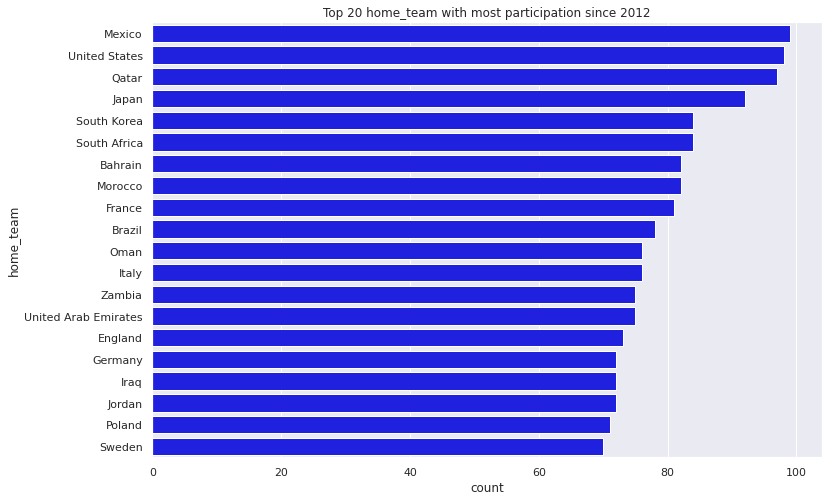

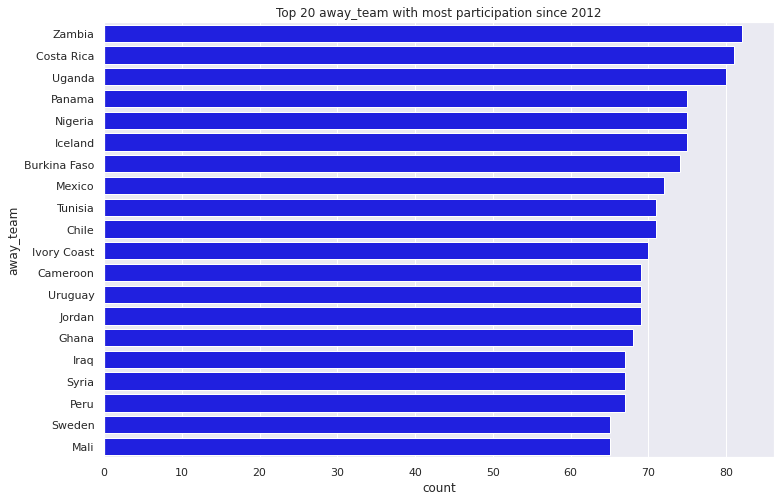

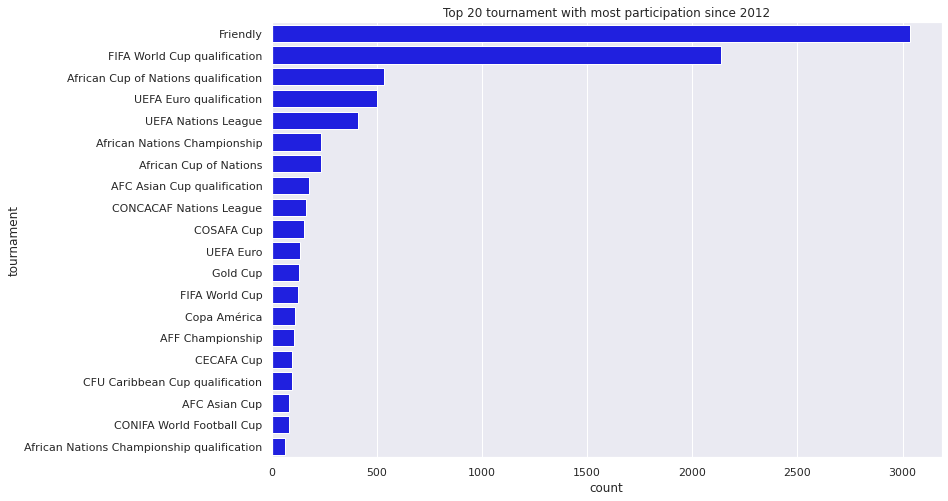

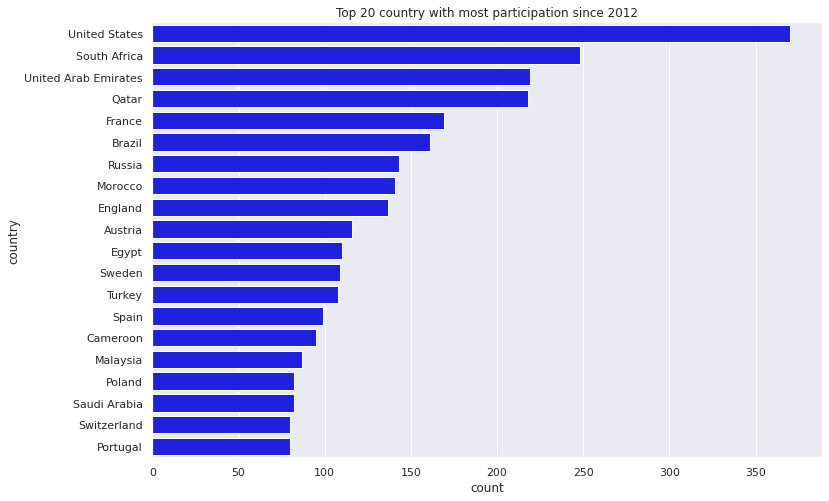

In [23]:
sns.set(rc = {'figure.figsize':(12,8)})
variables = ['home_team', 'away_team', 'tournament', 'country'  ]
for v in variables:
  data = df.sort_values(by=[v])
  sns.countplot(y=data[v], data=data, 
                order=df[v].value_counts().iloc[:20].index, orient = 'h', color='blue')
  plt.title(f'Top 20 {v} with most participation since 2012')
  plt.show()

### Countries participation and importance

#### Teams with the highest total number of goals

In [24]:
df['goal_diff'] = df['home_score'] - df['away_score']

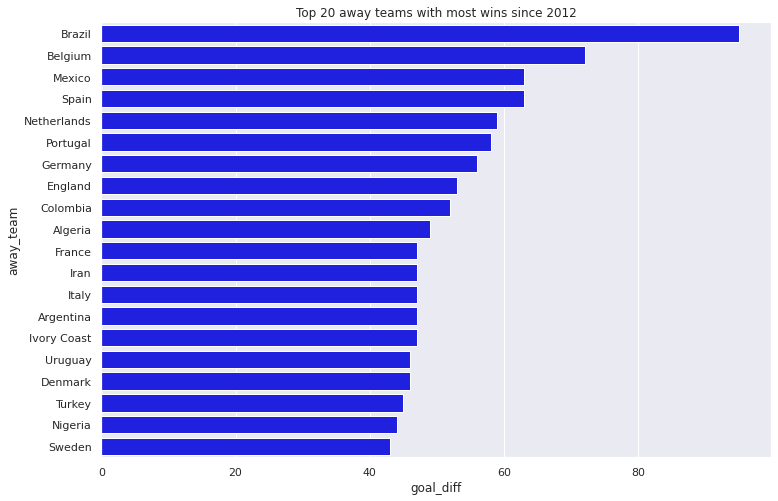

       away_team  goal_diff
33        Brazil         95
24       Belgium         72
144       Mexico         63
209        Spain         63
155  Netherlands         59
179     Portugal         58
84       Germany         56
69       England         53
50      Colombia         52
4        Algeria         49
79        France         47
105         Iran         47
110        Italy         47
11     Argentina         47
111  Ivory Coast         47
238      Uruguay         46
62       Denmark         46
230       Turkey         45
160      Nigeria         44
214       Sweden         43


In [25]:
# Away team
result_a = df.groupby('away_team')
result_a = df[df['goal_diff'] < 0]
result_a.goal_diff = result_a.goal_diff.abs()
result_a = result_a.groupby(['away_team'])['goal_diff'].agg('sum').reset_index()
result_a = result_a.sort_values(by='goal_diff', ascending=False).head(20)
sns.set(rc = {'figure.figsize':(12,8)})
sns.barplot(x='goal_diff', y='away_team', data=result_a, color='blue')
plt.title(f'Top 20 away teams with most wins since 2012')
plt.show()
print(result_a)

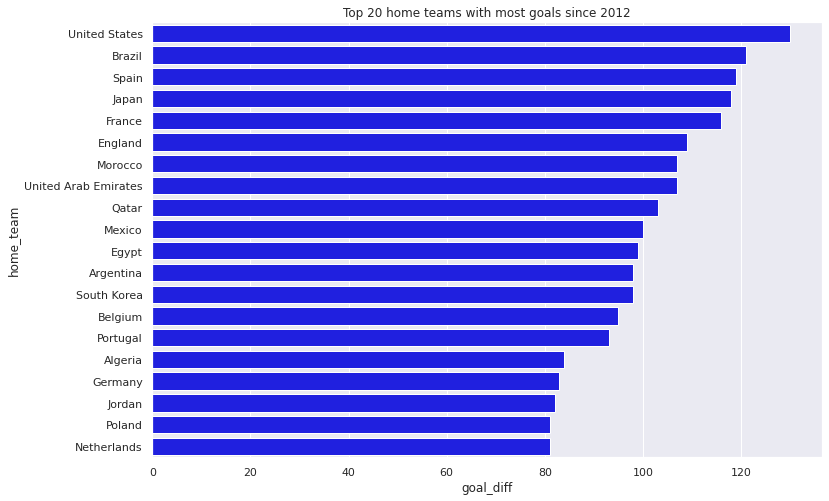

                home_team  goal_diff
243         United States        130
31                 Brazil        121
215                 Spain        119
116                 Japan        118
81                 France        116
71                England        109
153               Morocco        107
241  United Arab Emirates        107
186                 Qatar        103
147                Mexico        100
68                  Egypt         99
8               Argentina         98
212           South Korea         98
22                Belgium         95
183              Portugal         93
3                 Algeria         84
86                Germany         83
118                Jordan         82
182                Poland         81
158           Netherlands         81


In [26]:
# Home team
result_h = df.groupby('home_team')
result_h = df[df['goal_diff'] > 0]
result_h = result_h.groupby(['home_team'])['goal_diff'].agg('sum').reset_index()
result_h = result_h.sort_values(by='goal_diff', ascending=False).head(20)
sns.set(rc = {'figure.figsize':(12,8)})
sns.barplot(x='goal_diff', y='home_team', data=result_h, color='blue')
plt.title(f'Top 20 home teams with most goals since 2012')
plt.show()
print(result_h)

In [27]:
df = df.drop(columns=['goal_diff'],  axis=1)

#### More information about the teams

In [28]:
#Unique values in categorical columns
columns = ['home_team','away_team']
for col  in columns:
    print("Unique values in: ", col)
    print(df[col].unique())
    print(df[col].nunique())

Unique values in:  home_team
['Equatorial Guinea' 'Botswana' 'Gabon' 'Tunisia' 'Nigeria' 'Senegal'
 'Angola' 'Zambia' 'Oman' 'São Tomé and Príncipe' 'Ivory Coast' 'Kuwait'
 'Bahrain' 'Thailand' 'United States' 'Burkina Faso' 'Lebanon' 'Lesotho'
 'Trinidad and Tobago' 'Morocco' 'Ghana' 'Mali' 'Libya' 'Mexico' 'Panama'
 'Sudan' 'Niger' 'Romania' 'United Arab Emirates' 'Liberia' 'Paraguay'
 'North Korea' 'China PR' 'Grenada' 'Jamaica' 'Iran' 'Tanzania' 'Japan'
 'Nicaragua' 'Singapore' 'South Korea' 'Egypt' 'India' 'Armenia'
 'Bosnia and Herzegovina' 'Antigua and Barbuda' 'Australia' 'Austria'
 'Bolivia' 'Burundi' 'Chad' 'Chile' 'Congo' 'Croatia' 'Cyprus' 'Denmark'
 'Ecuador' 'El Salvador' 'England' 'Ethiopia' 'Gambia' 'Georgia' 'Germany'
 'Greece' 'Guinea-Bissau' 'Guyana' 'Hong Kong' 'Hungary'
 'Republic of Ireland' 'Israel' 'Italy' 'Kenya' 'Latvia' 'Luxembourg'
 'Madagascar' 'Malta' 'Moldova' 'Montenegro' 'New Zealand'
 'Northern Ireland' 'Palestine' 'Philippines' 'Poland' 'Rwanda'
 'Sey

In [29]:
home_top_40=pd.DataFrame(df["home_team"].value_counts().head(40))
home_top_40.columns=["Games played as home team"]
home_top_40

,Games played as home team
Mexico,99
United States,98
Qatar,97
Japan,92
South Korea,84
South Africa,84
Bahrain,82
Morocco,82
France,81
Brazil,78


In [30]:
away_top_40=pd.DataFrame(df["away_team"].value_counts().head(40))
away_top_40.columns=["Games played as away team"]
away_top_40

,Games played as away team
Zambia,82
Costa Rica,81
Uganda,80
Panama,75
Nigeria,75
Iceland,75
Burkina Faso,74
Mexico,72
Tunisia,71
Chile,71


* We observe that the teams who played the most matches are almost the same, with this information we decide to keep only the data of the qualified teams for the FIFA Wold Cup 2022.

#### Teams and groups for the FIFA World Cup 2022

Cleaning and Encoding.

In [31]:
# We define the groups and teams for Qatar 2022
group_A = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands']
group_B = ['England', 'Iran', 'United States', 'Wales']
group_C = ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland']
group_D = ['France', 'Denmark', 'Tunisia', 'Australia']
group_E = ['Spain', 'Germany', 'Japan', 'Costa Rica']
group_F = ['Belgium', 'Canada', 'Morocco', 'Croatia' ]
group_G = ['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
group_H = ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
all_teams=group_A +group_B +group_C +group_D +group_E +group_F +group_G +group_H

##### Cleaning

In [32]:
# We remove the data of the countries that are not part of the world cup 2022 
df.drop(df[~df['home_team'].isin(all_teams)].index, inplace = True)
df.drop(df[~df['away_team'].isin(all_teams)].index, inplace = True)
df.head(5)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
34005,Morocco,Tunisia,1,2,African Cup of Nations,Libreville,Gabon,True,2012
34031,Ghana,Tunisia,2,1,African Cup of Nations,Franceville,Gabon,True,2012
34060,Australia,Saudi Arabia,4,2,FIFA World Cup qualification,Melbourne,Australia,False,2012
34075,England,Netherlands,2,3,Friendly,London,England,False,2012
34079,Germany,France,1,2,Friendly,Bremen,Germany,False,2012


In [33]:
# List to obtain the unique countries values present in the dataset
list_teams = np.unique(df[['away_team','home_team']].values)
list_teams

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

##### Encode 

by FIFA Ranking at 23th of june 2022, information obtained from https://www.fifa.com/fifa-world-ranking/men?dateId=id13687

This method is used to minimize the number of columns.

In [34]:
teams_points = {'Argentina' : 1770.65, 'Australia' : 1483.73, 
                'Belgium': 1821.92, 'Brazil' : 1837.56, 'Cameroon' : 1484.95, 
                'Canada' : 1473.82, 'Costa Rica' : 1500.06, 'Croatia' : 1632.15, 
                'Denmark' : 1665.47, 'Ecuador' : 1463.74, 'England' : 1737.46, 
                'France' : 1764.85, 'Germany' : 1658.96, 'Ghana' : 1389.68, 
                'Iran' : 1558.64, 'Japan' : 1552.77, 'Mexico' : 1649.57, 
                'Morocco' : 1558.9, 'Netherlands' : 1679.41, 'Poland' : 1546.18, 
                'Portugal' : 1678.65, 'Qatar' : 1441.41, 
                'Saudi Arabia' : 1435.74, 'Senegal' : 1593.45, 
                'Serbia' : 1549.53, 'South Korea' : 1526.2, 'Spain' : 1716.93, 
                'Switzerland' : 1621.43, 'Tunisia' : 1507.86, 
                'United States' : 1635.01, 'Uruguay' : 1643.71, 
                'Wales' : 1582.13}

In [35]:
# Map the countries ranking points
df ['h_team_points'] = df['home_team'].map(teams_points)
df ['a_team_points'] = df['away_team'].map(teams_points)

In [36]:
df.head(5)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,h_team_points,a_team_points
34005,Morocco,Tunisia,1,2,African Cup of Nations,Libreville,Gabon,True,2012,1558.90,1507.86
34031,Ghana,Tunisia,2,1,African Cup of Nations,Franceville,Gabon,True,2012,1389.68,1507.86
34060,Australia,Saudi Arabia,4,2,FIFA World Cup qualification,Melbourne,Australia,False,2012,1483.73,1435.74
34075,England,Netherlands,2,3,Friendly,London,England,False,2012,1737.46,1679.41
34079,Germany,France,1,2,Friendly,Bremen,Germany,False,2012,1658.96,1764.85


In [37]:
# Remove the irrelevant columns
df = df.drop(['country', 'city', 'home_team', 'away_team'], axis=1)

In [38]:
df.head(5)

,home_score,away_score,tournament,neutral,year,h_team_points,a_team_points
34005,1,2,African Cup of Nations,True,2012,1558.90,1507.86
34031,2,1,African Cup of Nations,True,2012,1389.68,1507.86
34060,4,2,FIFA World Cup qualification,False,2012,1483.73,1435.74
34075,2,3,Friendly,False,2012,1737.46,1679.41
34079,1,2,Friendly,False,2012,1658.96,1764.85


### Tournaments importance

How many tournaments do we have?
What weight does each tournament have?

To answer this questions and encode the tournament feature, first we list the tournaments present in the dataset and count the number of registers in each case. We then group similar tournaments together, map the data using this clasification. Finally, using the FIFA Ranking Procedures - importance of match we set the weight for each group.

In [39]:
df.tournament.value_counts()

Friendly                                284
FIFA World Cup qualification            118
FIFA World Cup                           69
UEFA Nations League                      58
UEFA Euro                                35
UEFA Euro qualification                  20
Copa América                             16
Gold Cup                                 14
Confederations Cup                       12
African Cup of Nations                   10
AFC Asian Cup                             8
EAFF Championship                         6
Superclásico de las Américas              6
Kirin Challenge Cup                       5
African Cup of Nations qualification      4
CONCACAF Nations League                   4
African Nations Championship              3
Gulf Cup                                  3
WAFF Championship                         2
Kirin Cup                                 2
Arab Cup                                  1
Name: tournament, dtype: int64

In [40]:
Friendly = ['Friendly', 'Superclásico de las Américas', 'Intercontinental Cup']
Qualifications = ['FIFA World Cup qualification']
WC = ['FIFA World Cup', 'Confederations Cup']
Cups = ['African Cup of Nations qualification', 'African Cup of Nations', 
        'African Nations Championship qualification', 
        'African Nations Championship', 'Copa América qualification', 
        'Copa América', 'UEFA Euro qualification', 'UEFA Euro', 
        'UEFA Nations League', 'AFC Asian Cup qualification', 'AFC Asian Cup', 
        'CFU Caribbean Cup qualification', 'Oceania Nations Cup qualification',
        'Oceania Nations Cup', 'CONCACAF Nations League qualification', 
        'CONCACAF Nations League', 'Gold Cup qualification', 'Gold Cup', 
        'Arab Cup qualification', 'Arab Cup', 'COSAFA Cup', 'CECAFA Cup',
        'Gulf Cup', 'EAFF Championship', 'CFU Caribbean Cup', 'Baltic Cup']

NoOthers = ['Friendly', 'Qualifications', 'WC', 'Cups']

df['tournament'] = df['tournament'].apply(lambda x: x if x not in Friendly 
                                          else 'Friendly')
df['tournament'] = df['tournament'].apply(lambda x: x if x not in Qualifications 
                                          else 'Qualifications')
df['tournament'] = df['tournament'].apply(lambda x: x if x not in WC 
                                          else 'WC')
df['tournament'] = df['tournament'].apply(lambda x: x if x not in Cups 
                                          else 'Cups')
df['tournament'] = df['tournament'].apply(lambda x: x if x in NoOthers 
                                          else 'Others')

In [41]:
tournament_points = {'Friendly':10, 'Qualifications':25, 'Cups':20, 'WC':55, 'Others':8}

In [42]:
df['tournament_point'] = df['tournament'].map(tournament_points)

In [43]:
df = df.drop(['tournament'], axis=1)

In [44]:
df.head(5)

,home_score,away_score,neutral,year,h_team_points,a_team_points,tournament_point
34005,1,2,True,2012,1558.90,1507.86,20
34031,2,1,True,2012,1389.68,1507.86,20
34060,4,2,False,2012,1483.73,1435.74,25
34075,2,3,False,2012,1737.46,1679.41,10
34079,1,2,False,2012,1658.96,1764.85,10


### Setting the match winner 

Using the goal difference.

In [45]:
# Setting the match winner using the goal difference
df['match_result'] = np.where(df['home_score'] - df['away_score'] > 0, 'WIN', np.where(df['home_score'] - df['away_score'] < 0, 'LOSE', 'DRAW'))

In [46]:
df = df.drop(['home_score',	'away_score' ], axis=1)

### Encoding Neutral feature

In [47]:
df ['neutral'] = df['neutral'].map({True: 1, False: 0})

In [48]:
df.head(5)

,neutral,year,h_team_points,a_team_points,tournament_point,match_result
34005,1,2012,1558.90,1507.86,20,LOSE
34031,1,2012,1389.68,1507.86,20,WIN
34060,0,2012,1483.73,1435.74,25,WIN
34075,0,2012,1737.46,1679.41,10,LOSE
34079,0,2012,1658.96,1764.85,10,LOSE


### Final Shape

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 34005 to 43750
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neutral           680 non-null    int64  
 1   year              680 non-null    int64  
 2   h_team_points     680 non-null    float64
 3   a_team_points     680 non-null    float64
 4   tournament_point  680 non-null    int64  
 5   match_result      680 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 37.2+ KB


## Balance in the data

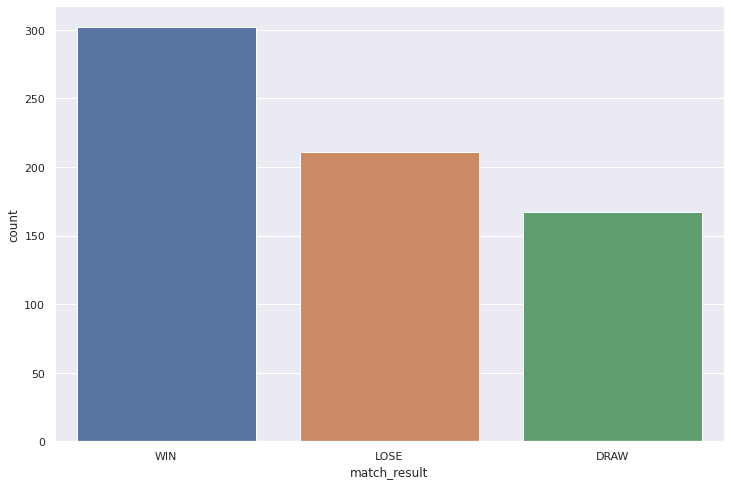

In [50]:
sns.set(rc = {'figure.figsize':(12,8)})
data = df.sort_values(by=['match_result'])
sns.countplot(x=data['match_result'], data=data, order=df['match_result'].value_counts().index)
plt.show()

## Correlation

<AxesSubplot:>

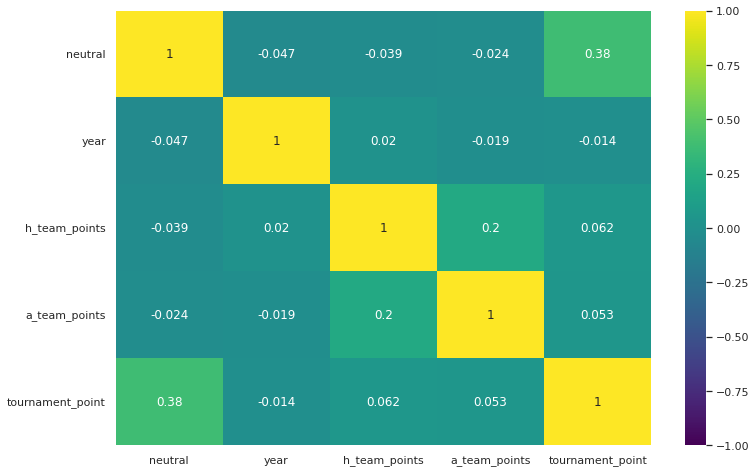

In [51]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True,cmap='viridis', vmax=1, vmin=-1, center=0)

## Modeling

In [52]:
X = df.drop(columns=['match_result'])
y = df['match_result']

In [53]:
# train-test split: train: before 2018(Russia WC), test: after 2018 (including WC)
Train = df[df['year'] < 2018]
Test = df[df['year'] >= 2018]

In [54]:
X_train = Train.drop('match_result', axis='columns')
y_train = Train['match_result']

X_test = Test.drop('match_result', axis='columns')
y_test = Test['match_result']

### class_weight

In [55]:
wins = len(df[df['match_result']=='WIN'])
draws = len(df[df['match_result']=='DRAW'])
loses = len(df[df['match_result']=='LOSE'])
total = wins + draws + loses

win_weight = total/wins
draw_weight = total/draws
lose_weight = total/loses

sample_weights = []
for index, value in y_train.items() :
    if value == 'WIN' :
        sample_weights.append(win_weight)
    elif value == 'DRAW' :
        sample_weights.append(draw_weight)
    elif value == 'LOSE' :
        sample_weights.append(lose_weight)
'''
class_weight=
sample_weight_vect = compute_sample_weight(class_weight= y=y_train)
'''

'\nclass_weight=\nsample_weight_vect = compute_sample_weight(class_weight= y=y_train)\n'

In [56]:
# Gradient Boosting:
model_GB = GradientBoostingClassifier(random_state=13)
#model_GB.fit(X_train, y_train, sample_weight=sample_weights)
model_GB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=13)

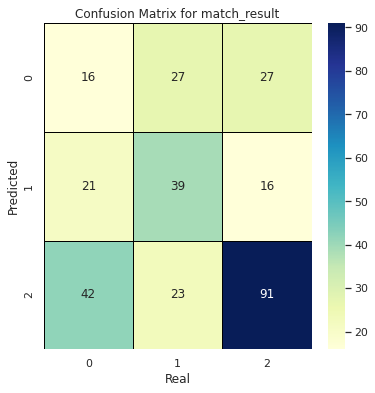

CLASSIFICATION REPORT: Match Result: 
               precision    recall  f1-score   support

        DRAW       0.23      0.20      0.21        79
        LOSE       0.51      0.44      0.47        89
         WIN       0.58      0.68      0.63       134

    accuracy                           0.48       302
   macro avg       0.44      0.44      0.44       302
weighted avg       0.47      0.48      0.47       302

The score with X_train & y_train is: 0.8095238095238095
The score for X_test & y_test is: 0.48344370860927155
Tree params: 
 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 13, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [57]:
# Metrics & Results:
y_pred = model_GB.predict(X_test)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for match_result")
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.show()

print(f'CLASSIFICATION REPORT: Match Result: \n {classification_report(y_test, y_pred)}')

# Get the score of train data just to verify its 1.
score = model_GB.score(X_train, y_train)
print(f'The score with X_train & y_train is: {score}')

#Get the score for the predictions:
score = model_GB.score(X_test, y_test)
print(f'The score for X_test & y_test is: {score}')

# Tree params
print(f'Tree params: \n {model_GB.get_params()}')

parámetro weights de GB model para ponderar win, draw, lose 

### Grid Search

In [62]:
# GRID SEARCH GB:
# A sample parameter
p_test = {'min_weight_fraction_leaf':[0.260, 0.270, 0.275], 'n_estimators':[90], 'max_depth':[2, 3, 4, 5], 'learning_rate':[0.07, 0.1, 0.12], 'min_samples_split':[2, 3], 'min_samples_leaf':[2, 3, 4]}

tuning = GridSearchCV(estimator=GradientBoostingClassifier(random_state=13,),
            param_grid = p_test, scoring='f1_weighted',n_jobs=4, cv=5)
tuning.fit(X_train, y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.12,
  'max_depth': 2,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.275,
  'n_estimators': 90},
 0.47494174202949424)

### Hypertune model evaluation

In [60]:
# Gradient Boosting after hyperparameter tunning:
tuned_GB = GradientBoostingClassifier(learning_rate=0.1, n_estimators=90, max_depth=4, random_state=13)
#model_GB.fit(X_train, y_train, sample_weight=sample_weights)
tuned_GB.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=90, random_state=13)

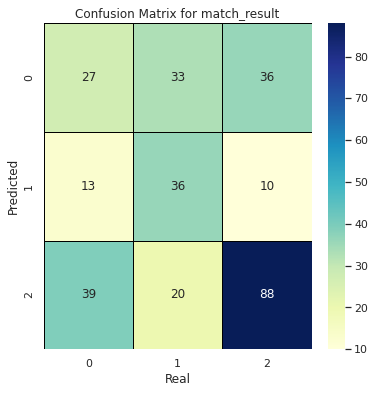

CLASSIFICATION REPORT: Match Result: 
               precision    recall  f1-score   support

        DRAW       0.28      0.34      0.31        79
        LOSE       0.61      0.40      0.49        89
         WIN       0.60      0.66      0.63       134

    accuracy                           0.50       302
   macro avg       0.50      0.47      0.47       302
weighted avg       0.52      0.50      0.50       302

The score with X_train & y_train is: 0.9365079365079365
The score for X_test & y_test is: 0.5
Tree params: 
 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 13, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [61]:
# Metrics & Results:
y_pred = tuned_GB.predict(X_test)

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for match_result")
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.show()

print(f'CLASSIFICATION REPORT: Match Result: \n {classification_report(y_test, y_pred)}')

# Get the score of train data just to verify its 1.
score = tuned_GB.score(X_train, y_train)
print(f'The score with X_train & y_train is: {score}')

#Get the score for the predictions:
score = tuned_GB.score(X_test, y_test)
print(f'The score for X_test & y_test is: {score}')

# Tree params
print(f'Tree params: \n {model_GB.get_params()}')

##  Prediction Example

In [ ]:
match = [1, 2022, 'Qatar', 'Uruguay', 'WC']

# If 'home_team' == 'Qatar': neutral=False, else neutral=True
if match[2] == 'Qatar' :
  match[0] = 0
else :
  match[0] = 1

match[2], match[3], match[4] = teams_points[match[2]], teams_points[match[3]], tournament_points[match[4]]

print('Predict match:\n', model_GB.predict([match]))

Predict match:
 ['LOSE']
